## Elaborated trees
The idea here is to use a heuristic that should create more uniformly spaced set of representatives.

It combines two ideas:

1. Instead of cover trees which adds as a center any point that is not yet covered. Here we further filter the points using a kmeans++ rule.
1. Once a node is punched through, we run an online version of kmeans++ to move each center to the center of mass of the points associated with it.



In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('../../Data/twoBlob.csv',header=None)
np.random.shuffle(data.values)
data = data.iloc[:10000,:]
print(data.shape)
data.head()

(10000, 5)


,0,1,2,3,4
0,4.237800,0.481390,-0.15535,-0.82852,0.033347
1,0.021065,0.831640,-0.18329,0.35067,-0.389050
2,-0.130270,-0.394450,-0.35267,-0.32236,-0.774040
3,1.060500,0.072523,0.00000,0.00000,0.000000
4,0.716800,0.013588,-0.40290,-0.23814,0.516690


In [3]:
#pd.plotting.scatter_matrix(data,figsize=[10,10]);

In [4]:
#estimate max distance
def _rand():
    return random.randint(0,data.shape[0])
def _dist(v1,v2):
    return sqrt(sum((v1-v2)**2))

D=[]
for i in range(4000):
    v1=np.array(data.iloc[_rand(),:])
    v2=np.array(data.iloc[_rand(),:])
    D.append(_dist(v1,v2))

5.801489399054091


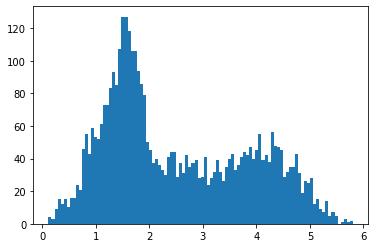

In [5]:
eps=max(D)
print(eps)
hist(D,bins=100);

In [6]:
eps

5.801489399054091

In [7]:
_MAX = finfo(type(eps)).max
_MAX

1.7976931348623157e+308

In [12]:
%%writefile CoverTree1.py

class CoverTree(object):
    def __init__(self,center,radius,path):
        self.center=center
        self.radius=radius
        self.counter=1  # number of points covered by this tree
        self.too_far=0  # count how many points were too far (should only be non-zero at root
        self.path=path
        self.children = []
    
    def dist_to_x(self,x):
        d=_dist(x,self.center)
        if d<self.radius:
            return d
        else:
            return _MAX
        
    def no_of_children(self):
        return len(self.children)
    def get_level(self):
        return len(self.path)
    
    def find_path(self,x):
        d= _dist(x,self.center)
        #print(str(self.path),d)
        if d>self.radius:
             return None
        if len(self.children)==0:
            return [self]
        else:
            for child in self.children:
                child_path = child.find_path(x)
                if child_path is None:
                    continue
                else:
                    return [self]+child_path
            return [self]

    def insert(self,x):
        path=self.find_path(x)
        if path is None:
            return False

        #found a non-trivial path
        leaf=path[-1]
        new=CoverTree(x,leaf.radius/2,leaf.path+(leaf.no_of_children(),))
        leaf.children.append(new)
        for node in path:
            node.counter +=1
        return True
            
        
    def collect_centers(self):
        '''Collect all of the centers defined by a tree
        returns a list where each element is a center, followed by the level of the center'''
        C=[(self.center,len(self.path))]
        if len(self.children)>0:
            for child in self.children:
                C = C+ child.collect_centers()
        return C
            
    def collect_nodes(self):
        '''returns a list of all nodes in the tree'''
        N=[self]
        if len(self.children)>0:
            for child in self.children:
                N=N+child.collect_nodes()
        return N

    def __str__(self):
        return str(self.path)+': r=%4.2f, no_child=%d, count=%d'%(self.radius,len(self.children),self.counter)

    def _str_to_level(self,max_level):
        s=self.__str__()+'\n'
        if self.get_level() < max_level and len(self.children)>0:
            for i in range(len(self.children)):
                s+=self.children[i]._str_to_level(max_level)
        return s    

Writing CoverTree1.py


In [13]:
%%writefile ElaboratedTrees1.py
class ElaboratedTree(CoverTree):
    def __init__(self,center,radius,path,mode='initial'):
        super().__init__(center,radius,path)
        self.covered_fraction = 0
        self.punch_through = False
        self.mode = mode         # 'initial' = node that has been started, but is not yet collecting
                                 # 'Collect' = collecting centers. Ends when covered fraction > thr
                                 # 'Tune' = Refine centers and collect statistics
                                 # 'PassThrough' = root node fixed: children can start collecting.


    def find_closest_child(self,x):
        """ find the child of this node that is closest to x
        :param x: 
        :returns: 
        :rtype: 
        """
        if self.no_of_children() ==0:
            return None,None
        _min_d = _MAX
        closest_child=None
        for child in self.children:
            _d = child.dist_to_x(x)
            if _d > child.radius:
                continue
            if _d < _min_d:
                closest_child=child
                _min_d=_d
        return closest_child,_min_d

    def find_path(self,x):
        """ Find path in tree that corresponds to the point x

        :param x: the input point

        :returns: path from root to leaf
        :rtype: a list of nodes
        """

        d= _dist(x,self.center)
        #print(str(self.path),d)
        if d>self.radius:
             return None
        if len(self.children)==0:
            return [self]
        else:
            closest_child,distance = self.find_losest(x)
            child_path = closest_child.find_path(x)
            if child_path is None:
                return [self]
            else:
                return [self]+child_path
    


    def conditionally_add_child(self,x):
        _child,d = self.find_closest_child(x)
        if self.no_of_children()==0:
            self.add_child(x)
            return True

        r=self.radius/2 
        print('d=%4.2f, r=%4.2f'%(d,r))
        if d is None or d<r: #Add only points that are at least radius/2 from closest center.
            return False
        else:                   # if >r/2 far from center use modified kmeans++ rule
            P=((d-r)/r)**2
            if random.random()<P:
                print('adding point with P=%f'%P)
                self.add_child(x)
                return True
            return False
            

    def add_child(self,x):
        """ Add child to node

        :param x: 

        """
        new=MuffledTree(x,self.radius/2,self.path+(self.no_of_children(),))
        self.children.append(new)

    def check_an_add(self,x):
        """ check altered kmeans++ condition and conditionally add point x
            Assumes mode of parent is such that addition is allowed
        :param x: 
        :returns: 
        :rtype: 

        """
        
    def insert(self,x):
        """ insert a new training example

        :param x: 
        :returns: flag indicating whether a non-trivial path was found. 
        :rtype: Flag

        """
        path=self.find_path(x)
        #if path is None:
        #    leaf=self
        #else:
        #    leaf=path[-1]

        #found a non-trivial path
        
        is_root=len(path)==1
        if is_root:  #root node, if does not cover x, always adds x as a child
            self.conditionally_add_child(x)
        else:  #not root
            print('not root, path len=',len(path))
            parent = path[-2]
            parent.update_statistics(x)


            
#             if parent.punch_through: #add new node
#                 leaf.add_child(x)
#                 if not parent.punch_through:
#                     parent.covered_fraction = (1-alpha)*parent.covered_fraction
#             else:     #don't add new node, instead, update parent statistics
#                 parent.covered_fraction = (1-alpha)*parent.covered_fraction + alpha
#                 if not parent.punch_through and parent.covered_fraction>thr:
#                     print('node'+str(parent.path)+\
#                           'punched through frac=%7.5f, count= %d, siblings=%2d'%(parent.covered_fraction,parent.counter,parent.no_of_children()))
#                     parent.punch_through=True  # this is a latch, once the leaf is punched through it remains so forever
            
        for node in path:
            node.counter +=1
        return True

    def __str__(self):
        return str(self.path)+': r=%4.2f, no_child=%d, count=%d, cov_frac=%4.3f, punch_through=%1d'\
                %(self.radius,len(self.children),self.counter,self.covered_fraction,int(self.punch_through))

def gen_scatter(T,data,level=0):
    C=[]
    for i in range(data.shape[0]):
        point=np.array(data.iloc[i,:])
        C.append(T.find_path(point)[-1].path[level])

    figure(figsize=[15,5])
    scatter(data[0],data[1],s=1,c=C,alpha=0.2)
    t='Level=%d, colors=%d'%(level,max(C)+1)
    title(t);


Writing ElaboratedTrees1.py


In [11]:
for i in range(1,data.shape[0]):
#for i in range(1,2000):
    point=np.array(data.iloc[i,:])
    T.insert(point)

NameError: name 'MuffledTree' is not defined

In [117]:
T.children


[]

In [90]:
print(T._str_to_level(3))

(): r=5.76, no_child=0, count=10000, cov_frac=0.000, punch_through=0



In [71]:
Nodes = T.collect_nodes()
C=[]
for node in Nodes:
    if node.punch_through:
        n=node.no_of_children()
        d=log(n)/log(2.)
        if n<8:
            C.append((node.center,d,node.path)) 
centers=np.array([c[0] for c in C])
D=[c[1] for c in C]
max_d=max(D)
S=[(max_d+3-d)*50 for d in D]

34


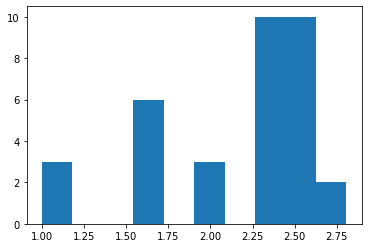

In [72]:
print(len(C))
hist(D);

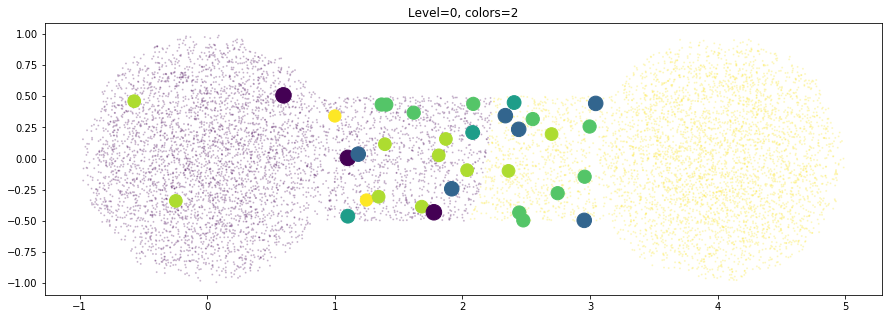

In [73]:
gen_scatter(T,data,level=0)
scatter(centers[:,0],centers[:,1],c=D,s=S)

## Suppressing high dimension regions
By collecting only nodes that have at most 6 children we concentrate our samples on the 1D connector